In [1]:
import pandas as pd 
from datetime import datetime
from forex_python.converter import CurrencyRates
import re
import random
import matplotlib.pyplot as plt

In [2]:
Expedia_hotels = pd.read_csv('Expedia_hotels.csv')

C:\Users\yarin\AppData\Local\Temp\ipykernel_19560\1586826330.py:1: DtypeWarning: Columns (13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  Expedia_hotels = pd.read_csv('Expedia_hotels.csv')


In [53]:
df = Expedia_hotels.copy()

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Snapshot                36000 non-null  object 
 1   Index                   36000 non-null  int64  
 2   Hotel Name              35980 non-null  object 
 3   TTT                     35980 non-null  float64
 4   LOS                     35980 non-null  float64
 5   Grade                   35468 non-null  float64
 6   Num of Reviews          35468 non-null  object 
 7   Curr Price              35980 non-null  object 
 8   Original Price          15342 non-null  object 
 9   Percentage of discount  35980 non-null  float64
 10  Distance from center    35980 non-null  float64
 11  Type of room            35980 non-null  float64
 12  Location grade          35980 non-null  float64
 13  Is refundable           35980 non-null  object 
 14  Late payment            35980 non-null

In [55]:
#taking only the date form the timestamp
df['Snapshot'] = df['Snapshot'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())
#keep the firt 100 hotels in each search
df = df.loc[df['Index'] < 100]

#increase the index in one to avoid the 0 index
df['Index'] = df['Index'] + 1

#convert from float to int
df['TTT'] = df['TTT'].astype('int64')
df['LOS'] = df['LOS'].astype('int64')


In [56]:
#we can see that we have 6 hotels with no grade, we can check if they have reviews
df.loc[pd.isnull(df['Grade'])]['Hotel Name'].value_counts()

Latisha luxury place                148
Moxy Brooklyn Willamsburg           115
The FIDI Hotel                      111
The Ritz-Carlton New York, NoMad    107
The Flat NYC                         23
Latisha house                         2
Name: Hotel Name, dtype: int64

In [57]:
#we see that the hotels without grade have no reviews
df.loc[pd.isnull(df['Num of Reviews'])]['Hotel Name'].value_counts()

Latisha luxury place                148
Moxy Brooklyn Willamsburg           115
The FIDI Hotel                      111
The Ritz-Carlton New York, NoMad    107
The Flat NYC                         23
Latisha house                         2
Name: Hotel Name, dtype: int64

In [58]:
#keep only the digits
df['Num of Reviews'] = df['Num of Reviews'].apply(lambda x: int(re.sub("[^0-9]", "", x)) if not pd.isnull(x) else x)

In [59]:
#check how much hotels have only one review, that can tell us if the hotels without reviews are likely to have zero reviews
df.loc[df['Num of Reviews'] == 1].shape

(8, 17)

In [60]:
#df['Num of Reviews'] = df['Num of Reviews'].fillna(0)

In [61]:
df['Grade'].describe()

count    29494.000000
mean         8.404733
std          0.645410
min          5.600000
25%          8.000000
50%          8.600000
75%          8.800000
max         10.000000
Name: Grade, dtype: float64

(array([ 151.,   64.,  508., 1308., 1539., 7276., 7958., 7747., 2612.,
         331.]),
 array([ 5.6 ,  6.04,  6.48,  6.92,  7.36,  7.8 ,  8.24,  8.68,  9.12,
         9.56, 10.  ]),
 <BarContainer object of 10 artists>)

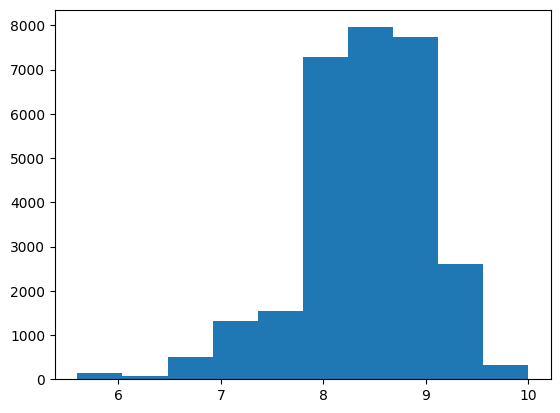

In [62]:
#lets see the histogram of the grades
plt.hist(df['Grade'])

In [13]:
#we choose to fill the missing values with a random number between 5 and 6 - whiche means that the hotel has a low grade
#df['Grade'] = df['Grade'].fillna(round(random.uniform(5, 6),1))

In [63]:
df['Curr Price'] = df['Curr Price'].apply(lambda x: x.split('€')[1])

In [64]:
df['Original Price'] = df['Original Price'].apply(lambda x: x.split('€')[1] if not pd.isnull(x) else x)

In [65]:
df['Original Price']

0          360
1          NaN
2          493
3          NaN
4          NaN
         ...  
35975      NaN
35976    1,958
35977    2,150
35978      NaN
35979      NaN
Name: Original Price, Length: 30000, dtype: object

In [66]:
#fill the original price with the current price if it is missing
df['Original Price'] = df.apply(lambda x: x['Curr Price']  if pd.isnull(x['Original Price']) else x['Original Price'], axis = 1)
df['Original Price']

0          360
1          217
2          493
3          328
4          428
         ...  
35975    1,656
35976    1,958
35977    2,150
35978    1,926
35979    1,461
Name: Original Price, Length: 30000, dtype: object

In [67]:
#convert the prices to int
df['Original Price'] = df['Original Price'].apply(lambda x: int(x.replace(',','')))
df['Curr Price'] = df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [68]:
df['Original Price']  

0         360
1         217
2         493
3         328
4         428
         ... 
35975    1656
35976    1958
35977    2150
35978    1926
35979    1461
Name: Original Price, Length: 30000, dtype: int64

In [69]:
#create dictionary with the exchange rate for each date
c = CurrencyRates()
x = df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('EUR','USD', date) 



In [70]:
curr_dict[df['Snapshot'].loc[0]]

1.0646

In [71]:
df[['Original Price','Curr Price']]

,Original Price,Curr Price
0,360,278
1,217,217
2,493,449
3,328,328
4,428,428
...,...,...
35975,1656,1656
35976,1958,1647
35977,2150,1936
35978,1926,1926


In [72]:
#multiply the prices by the exchange rate and divide by the LOS to get price per night
df['Original Price'] = df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
df['Curr Price'] = df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)


In [73]:
df['Original Price'] = df['Original Price'].apply(lambda x: round(x,1))
df['Curr Price'] = df['Curr Price'].apply(lambda x: round(x,1))

In [74]:
df[['Original Price','Curr Price']]

,Original Price,Curr Price
0,383.3,296.0
1,231.0,231.0
2,524.8,478.0
3,349.2,349.2
4,455.6,455.6
...,...,...
35975,349.3,349.3
35976,412.9,347.4
35977,453.4,408.3
35978,406.2,406.2


In [75]:
#drop unrelevant columns
df.drop(['Percentage of discount', 'Distance from center', 'Type of room',
       'Location grade'], axis = 1, inplace=True)

In [76]:
#convert the columns to int
df[['Is refundable','Late payment', 'Option Member']] = df[['Is refundable','Late payment', 'Option Member']].astype('int64')

In [77]:
df['Extras included'] = df['Extras included'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [29]:
df.head(10)

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Is refundable,Late payment,Extras included,Option Member
0,2023-03-06,1,Hotel 32 32,1,1,8.0,1296.0,296.0,383.3,0,0,0,0
1,2023-03-06,2,Sonesta Simply Suites Jersey City,1,1,8.4,1002.0,231.0,231.0,1,0,0,0
2,2023-03-06,3,Park Lane New York,1,1,8.8,305.0,478.0,524.8,0,0,0,0
3,2023-03-06,4,Arlo Midtown,1,1,9.2,3123.0,349.2,349.2,1,0,0,1
4,2023-03-06,5,"PUBLIC, an Ian Schrager hotel",1,1,8.0,1465.0,455.6,455.6,0,0,0,1
5,2023-03-06,6,Hard Rock Hotel New York,1,1,9.2,716.0,577.0,577.0,1,0,0,1
6,2023-03-06,7,Hotel Edison Times Square,1,1,7.8,2758.0,272.5,272.5,1,0,1,1
7,2023-03-06,8,YOTEL New York Times Square,1,1,7.0,1889.0,234.2,255.5,0,0,0,1
8,2023-03-06,9,Moxy Brooklyn Willamsburg,1,1,5.8,0.0,257.6,257.6,0,0,0,0
9,2023-03-06,10,New York Marriott Marquis,1,1,9.0,1543.0,572.8,572.8,0,0,0,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 35979
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Snapshot         30000 non-null  object 
 1   Index            30000 non-null  int64  
 2   Hotel Name       30000 non-null  object 
 3   TTT              30000 non-null  int64  
 4   LOS              30000 non-null  int64  
 5   Grade            29494 non-null  float64
 6   Num of Reviews   29494 non-null  float64
 7   Curr Price       30000 non-null  float64
 8   Original Price   30000 non-null  float64
 9   Is refundable    30000 non-null  int64  
 10  Late payment     30000 non-null  int64  
 11  Extras included  30000 non-null  int64  
 12  Option Member    30000 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 4.2+ MB


Exploration + Data preprocessing

In [31]:
import seaborn as sns

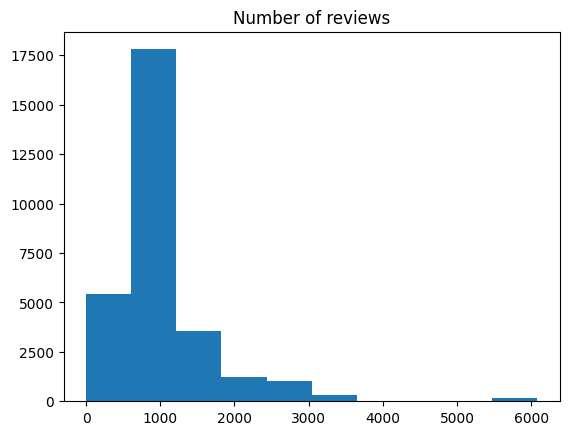

In [79]:
plt.hist(df['Num of Reviews'])
plt.title('Number of reviews')
plt.show()

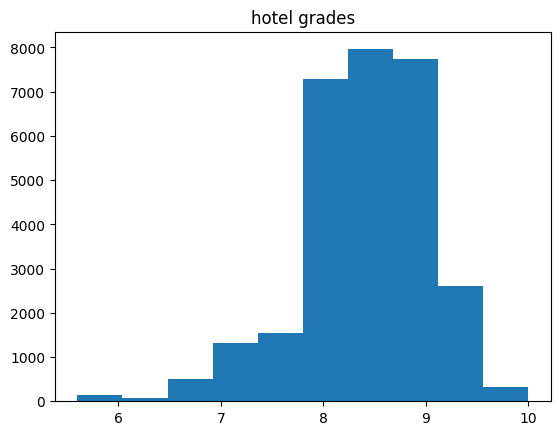

In [80]:
plt.hist(df['Grade'])
plt.title('hotel grades')
plt.show()

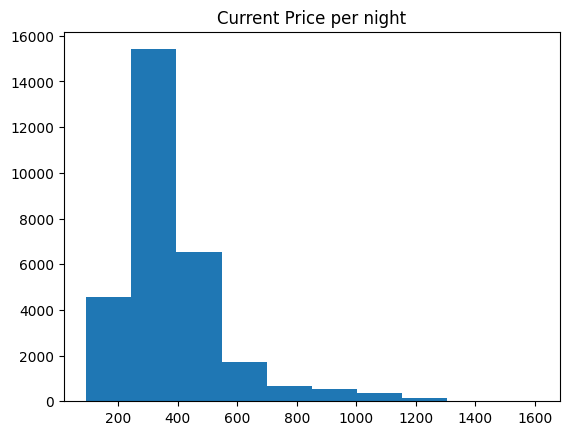

In [81]:
plt.hist(df['Curr Price'])
plt.title('Current Price per night')
plt.show()

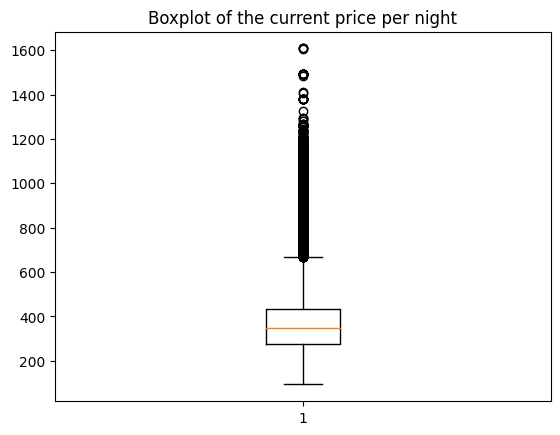

In [82]:
plt.boxplot(df['Curr Price'])
plt.title('Boxplot of the current price per night')
plt.show()

remove outliers with IQR

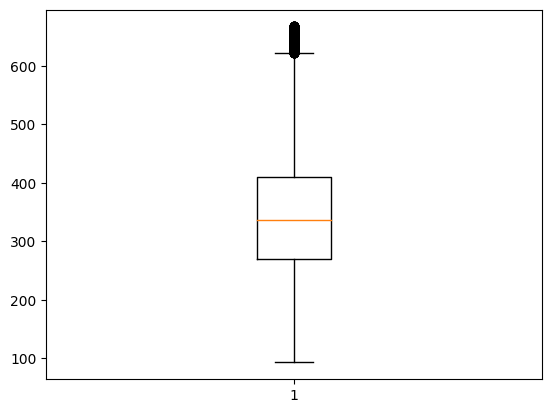

In [83]:
df_q1=df['Curr Price'].quantile(0.25)
df_q3=df['Curr Price'].quantile(0.75)

price_IQR = df_q3-df_q1

prices_lower_limit = df_q1 - (1.5 * price_IQR)
prices_upper_limit = df_q3 + (1.5 * price_IQR)

price_filter = df['Curr Price'].apply(lambda x: x > prices_lower_limit and x < prices_upper_limit)

filtered_prices_df = df[price_filter]

plt.boxplot(filtered_prices_df['Curr Price'])
plt.show()


In [84]:
filtered_prices_df['Curr Price'].describe()

count    28075.000000
mean       347.789581
std        106.631390
min         92.800000
25%        269.100000
50%        337.100000
75%        410.400000
max        667.500000
Name: Curr Price, dtype: float64

C:\Users\yarin\AppData\Local\Temp\ipykernel_19560\2201439202.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(filtered_prices_df.corr(), annot=True)


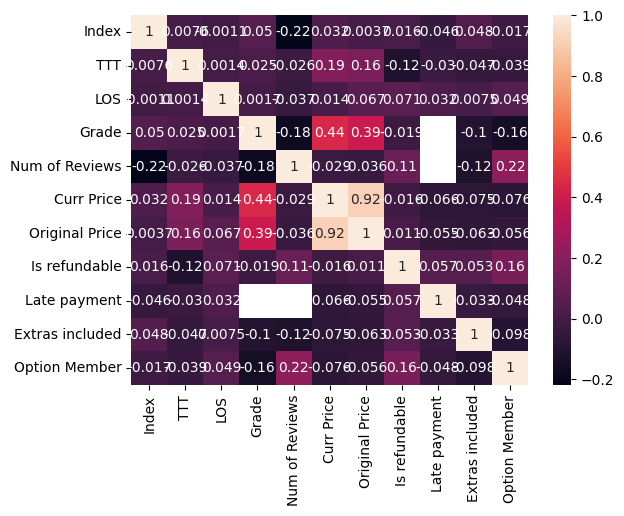

In [87]:
sns.heatmap(filtered_prices_df.corr(), annot=True)
plt.show()

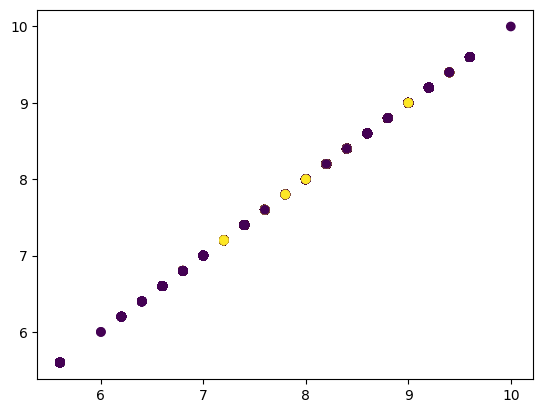

In [95]:
plt.scatter(filtered_prices_df['Grade'], filtered_prices_df['Grade'], c=filtered_prices_df['Extras included'])

In [92]:
df.Grade.sort_values().unique()

array([ 5.6,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,
        8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6, 10. ,  nan])